# Importing the required libraries

In [ ]:
%matplotlib inline
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import nltk
import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score,classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import spacy
import it_core_news_sm
from nltk.stem.snowball import SnowballStemmer

In [2]:
def generate_wordclouds(X_tfidf, y_test, word_positions):
    class_ids = set(y_test)
    top_count = 100
    
    for class_id in class_ids:
       
    # compute the total tfidf for each term in the cluster
        tfidf = X_tfidf[y_test == class_id]
        tfidf_sum = np.sum(tfidf, axis=0) # numpy.matrix
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1) 
        top_indices = tfidf_sum.argsort()[-top_count:]
        
        term_weights = {word_positions[idx]: tfidf_sum[idx] for idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Class {class_id}")
        
    return class_ids

class LemmaStemTokenizer(object):
    def __init__(self):
        self.lemmatizer = it_core_news_sm.load(disable=["parser"])
        self.stemmer = SnowballStemmer("italian")
        #self.lemmatizer = spacy.load("it_core_news_sm",disable=["parser"])
    
    def __call__(self, document):
        lemmas = []
        rmv_punct = str.maketrans('', '', string.punctuation)
        parts_of_speech = ['DET','PRON','CONJ','SCONJ','X','SPACE']
        
        for token in self.lemmatizer(document):
            lemma = token.lemma_
            
            # search punctation in a string and clean
            if re.search(r'[^\w\s]', lemma) and re.search(r'[\w^\s]', lemma):
                lemma = lemma.translate(rmv_punct)
                if len(lemma) > 2:
                    token = self.lemmatizer(lemma.translate(rmv_punct))[0]
                    lemma = token.lemma_
        
            # filter out any tokens not containing significant value(e.g.raw punctuation)
            if lemma not in string.punctuation and \
                len(lemma) > 2 and \
                len(lemma) < 20 and \
                token.pos_ not in parts_of_speech and \
                not re.search(r'\d', lemma):
                lemma = self.stemmer.stem(lemma)
                lemmas.append(lemma)
                
        return lemmas

# Reading and Extracting data from .csv files

In [3]:
df_dev = pd.read_csv('development.csv')[['text','class']]
df_eval = pd.read_csv('evaluation.csv')

# Data exploration

In [4]:
# Dim dataset
df = pd.concat([df_dev, df_eval], sort=False)
print("Dimensions datasets\n",len(df_dev), len(df_eval), len(df))

# Controll if text column has empty cells
print("\nEmpty text values\n",df["text"].isna().any(axis=0))

# Controll if class column has empty cells
print("\nEmpty class values\n",df_dev["class"].isna().any(axis=0))

Dimensions datasets
 28754 12323 41077

Empty text values
 False

Empty class values
 False


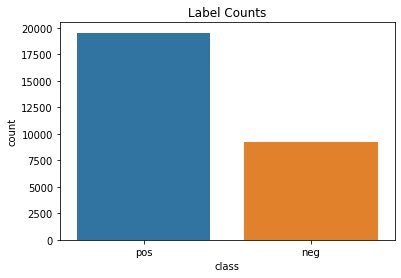

In [5]:
# The count of each of the two classes 
# 67% / 33% imbalance
fig2 = sns.countplot(x= 'class',data = df_dev)
plt.title('Label Counts')
plot = fig2.get_figure()
plot.savefig('count_plot.png')

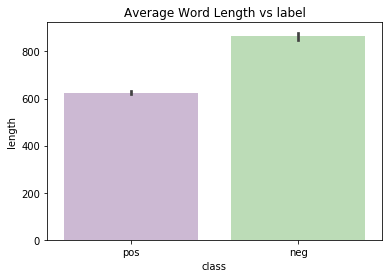

In [6]:
# Average Word Length vs class
df_dev['length'] = df_dev['text'].apply(len)
fig1 = sns.barplot('class','length',data = df_dev,palette='PRGn')
plt.title('Average Word Length vs label')

plot = fig1.get_figure()
plot.savefig('barplot_avg_word.png')

# Feature Engineering

In [7]:
lemmaStemTokenizer = LemmaStemTokenizer()
stopword = ['aver','esser','all','dal','dall','del','nel','nell','sul','sull','dell','per','poi']
vectorizer = TfidfVectorizer(tokenizer=lemmaStemTokenizer,
                             stop_words = stopword,
                             ngram_range = (1,2),
                             strip_accents="ascii",
                             lowercase = True,
                             max_df=0.25, min_df=3)

In [8]:
train_valid_mask = ~df["class"].isna()

X = df.drop(columns=["class"]).values
y = df["class"].values

X_tfidf = vectorizer.fit_transform(X.ravel())
# len(vectorizer.get_feature_names())

In [9]:
X_train_valid = X_tfidf[train_valid_mask.to_numpy().nonzero()]
y_train_valid = y[train_valid_mask]
X_eval = X_tfidf[(~train_valid_mask).to_numpy().nonzero()]

{'neg', 'pos'}

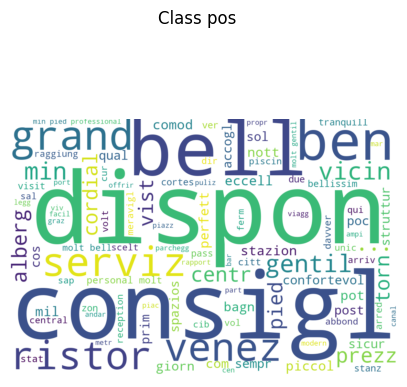

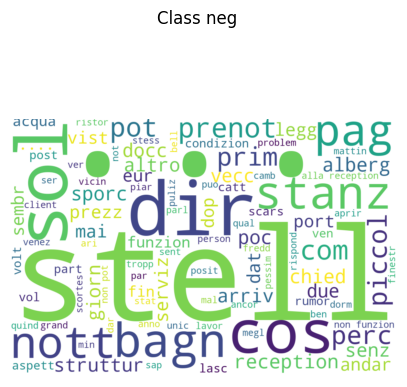

In [10]:
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
generate_wordclouds(X_train_valid, y_train_valid, word_positions)

# Model Selection and Machine Learning

In [ ]:
# Let’s experiment many classifiers.
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    SVC(),
    RandomForestClassifier(),
    MLPClassifier()
]

# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}

# K-Fold with 5 splits
kfold = KFold(n_splits=5, shuffle=True)

for train_indices, test_indices in kfold.split(X_train_valid, y_train_valid):
    # Prepare splits
    X_train_res = X_train_valid[train_indices]     # Use fancy indexing to extract data
    y_train_res = y_train_valid[train_indices]
    X_test = X_train_valid[test_indices]
    y_test = y_train_valid[test_indices]
    
    for model in models:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)

        results[model.__class__.__name__]['accuracy'].append(accuracy_score(y_test, y_pred))
        results[model.__class__.__name__]['f1_score'].append(f1_score(y_test, y_pred,average='weighted'))

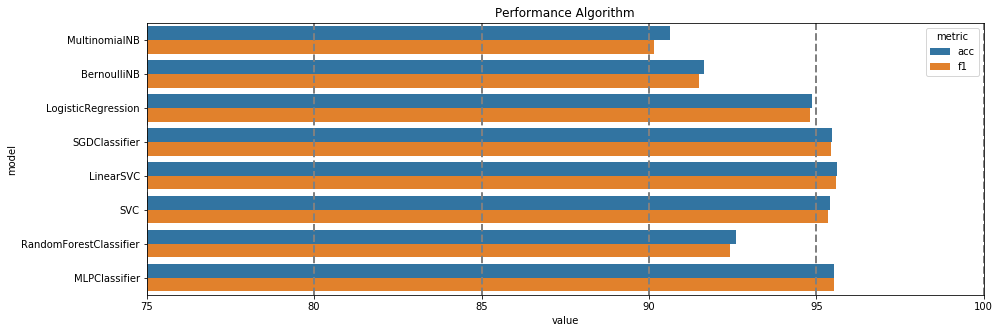

In [169]:
# Print result
metrics = []

for model, d in results.items():
    metrics.append([model,"acc",(sum(d['accuracy']) / len(d['accuracy']) * 100)])
    metrics.append([model,"f1",(sum(d['f1_score']) / len(d['f1_score']) * 100)])
  
metrics = np.array(metrics)
metrics = pd.DataFrame({'model': metrics[:, 0], 'metric': metrics[:, 1], 'value': metrics[:, 2]})
metrics['value'] = metrics['value'].astype(float)

plt.figure(figsize=(15,5))
plt.xlim(75,100)
plt.grid(color='grey', linestyle='--', linewidth=2)
fig3 = sns.barplot(x="value", y="model", hue="metric", data=metrics)

plt.title('Performance Algorithm') 
plot = fig3.get_figure()
plot.savefig('plot_performance.png')

In [28]:
# The best classifier is the Linear Support Vector Classification 
X_train, X_test, y_train, y_test = train_test_split(X_train_valid, y_train_valid, test_size=0.2,stratify=y_train_valid)

svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [29]:
# Validate model
y_test_pred = svc.predict(X_test)

In [30]:
# Precision, recall, f1, support: for each class
acc = accuracy_score(y_test,y_test_pred)
f1 = f1_score(y_test,y_test_pred,average='weighted')
p, _, _, _ = precision_recall_fscore_support(y_test,y_test_pred)

print(f"Accuracy = {acc:.3f}")
print(f"f1_weighted_score = {f1:.3f}")
print(classification_report(y_test_pred,y_test))

Accuracy = 0.971
f1_weighted_score = 0.971
              precision    recall  f1-score   support

         neg       0.95      0.96      0.96      1814
         pos       0.98      0.98      0.98      3937

    accuracy                           0.97      5751
   macro avg       0.97      0.97      0.97      5751
weighted avg       0.97      0.97      0.97      5751



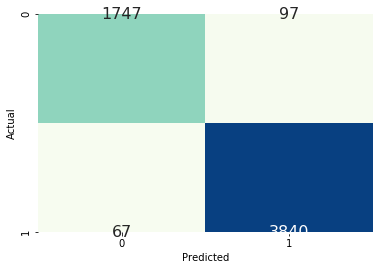

In [31]:
# Build the confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

# Plot the result
label_names = np.arange(p.shape[0])
conf_mat_df = pd.DataFrame(conf_mat, index = label_names, columns = label_names)
conf_mat_df.index.name = 'Actual'
conf_mat_df.columns.name = 'Predicted'
fig = sns.heatmap(conf_mat_df, annot=True, cmap='GnBu', 
            annot_kws={"size": 16}, fmt='g', cbar=False)
plt.show()
plot = fig.get_figure()
plot.savefig('confusion_matrix.png')

# Tuning and Validation

In [11]:
# gridsearch
param_grid = [
    {'C': [1, 1.5, 2, 2.5, 3, 3.5], 
     'penalty' : ['l1','l2'],
     'tol':[1e-01,1e-02,1e-03],
     'multi_class': ['ovr'],
     'class_weight' : ['balanced', None],
     'random_state' : [42]
    }
]

gs = GridSearchCV(LinearSVC(), param_grid, scoring="f1_weighted", n_jobs=-1, cv=5)

gs.fit(X_train_valid, y_train_valid)
y_eval = gs.predict(X_eval)

gs.best_score_,gs.best_params_

(0.9672990289699677,
 {'C': 1.5,
  'class_weight': 'balanced',
  'multi_class': 'ovr',
  'penalty': 'l2',
  'random_state': 42,
  'tol': 0.01})

In [12]:
# print result
pd.DataFrame(y_eval, index=df[~train_valid_mask].index).to_csv("output.csv",index_label="Id", header=["Predicted"])